## 1. Introduction

In this notebook we will examine the performance of various clustering algorithms on a medium sized NLP dataset. We will try different text vectorization methods with different settings.
We will perform some hyperparameter tuning to study those effects and we will compare the performance of the unsupervised clustering methods to a supervised method.

The main questions we would like to answer are:
1. What is the effect of different text vectorizers?
2. What is the effect of the amount of features to allow for a text vectorizer?
3. What is the performance of using different KMeans clustering algorithms?
4. What is the effect of choosing different number of iterations for a clustering algorithm?

Note that if you would like to rerun this notebook than take into account a runtime of a few hours on a high-end notebook or desktop. The runtime can be improved by trimming down the amount of iterations used by the various clustering methods. This will however affect the achieved performance in a negative way.

Note! Originally I started out with also DBScan and AgglomerativeClustering. Both turned out to be way to slow for the number of samples. After running my laptop a whole night on AgglomerativeClustering for just 1 experiments it still wasn't completely finished. At that moment I decided to only use KMeans.

Next let's start with importing all the required Python modules.

In [1]:
# Import Modules
import itertools
import numpy as np
import os
import pandas as pd
import tarfile
import time
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from urllib.request import urlopen

# NLTK for English Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Token Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning Models
import faiss
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier

# Surpress Warnings
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category = ConvergenceWarning)

# Pandas Display Settings
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Dataset

The dataset I've chosen to use is a medium sized dataset containing news articles. The dataset is a subset of the AG news dataset and contains a subset of the articles. The original AG news dataset contains about 1 million news articles. The AG News Subset contains a training file with 120K news articles and a test file with 7600 news articles.

Originally the AG News Subset is a part of the [Tensorflow Datasets - AG_news_subset](https://www.tensorflow.org/datasets/catalog/ag_news_subset). I've re-used some of the original TF dataset code to be able to download the original text/csv files and not use the TFRecords files that the Tensorflow Datasets normally provide.

For each news article the datasets contain a:
1. title
2. description
3. label

The labels are in a range of 1 - 4. To allow for easy using with the clustering and label permutations all labels are subtracted with 1 to modify the range to be within 0 - 3.

On data loading the class names for each label are merged with the training and test files. The following categories are present in the dataset:
1. World = 0
2. Sports = 1
3. Business = 2
4. Sci/Tech = 3

Lets get started by downloading and parsing the dataset and moving on to the Exploratory Data Analysis.

In [2]:
# AG News Subset Download URL from TFDS
AGNEWSSUBSET_URL = 'https://drive.google.com/uc?export=download&id=0Bz8a_Dbh9QhbUDNpeUdjb0wxRms'
AGNEWSSUBSET_DIR = './' 

# Download Tar.Gz File and Extract
with urlopen(AGNEWSSUBSET_URL) as targzstream:
    thetarfile = tarfile.open(fileobj = targzstream, mode = "r|gz")
    thetarfile.extractall(AGNEWSSUBSET_DIR)
    
# List Dataset files
agnewssubset_files = os.listdir(AGNEWSSUBSET_DIR + 'ag_news_csv/')
print(agnewssubset_files)

# Load Train Csv
train_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/train.csv', names = ['label', 'title', 'description'])
train_df = train_df.sample(frac = 1.0, random_state = 42) 

# Load Test Csv
test_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/test.csv', names = ['label', 'title', 'description'])

# Modify Labels to range 0 .. n-1
train_df.label = train_df.label - 1
test_df.label = test_df.label - 1

# Load Classes
classes_df = pd.read_csv(AGNEWSSUBSET_DIR + 'ag_news_csv/classes.txt', names = ['category'], delimiter = "\t")

# Join Classes to Train and Test
classes_df['label'] = classes_df.index
train_df = classes_df.merge(train_df)
test_df = classes_df.merge(test_df)

['classes.txt', 'readme.txt', 'test.csv', 'train.csv']


## 3. Exploratory Data Analysis

In this EDA we will take a closer look at the dataset we will be using. First let's examine the shape of the training dataset.

In [3]:
train_df.shape

(120000, 4)

We can see we have 120K of rows (as already stated in the previous dataset description) and 4 different columns.

Let's look at a few records from the training dataset.

In [4]:
train_df.head(10)

,category,label,title,description
0,World,0,Google Cuts Its IPO Price Range,"SAN JOSE, Calif. - In a sign that Google Inc.'s initial public offering will not be as hot or big as expected, the Internet search giant slashed its estimated per-share price range and reduced the number of shares to be sold by insiders..."
1,World,0,US genocide charge is Bush election ploy - Sudan FM (AFP),AFP - Sudan's foreign minister rejected US charges of genocide in the western region of Darfur as a reelection ploy by US President George W. Bush.
2,World,0,Stop croc water swimming: coroner,"THE public still did not appreciate how frighteningly dangerous crocodiles were, even after the fatal mauling of a German tourist two years ago, a coroner said today."
3,World,0,Construction Spending Hits All-Time High,"WASHINGTON - Construction spending surged in August to the highest level on record, while manufacturing grew at a slower pace in September, offering mixed signals about the economy's strength. The Commerce Department reported Friday that the value of buildings put in place clocked in at a seasonally adjusted annual rate of \$1.02 trillion, a record high..."
4,World,0,US Considering Incentives for Iran,"Resigning Iranian Vice-President Mohammad Ali Abtahi, center, and newly appointed Vice-President Majid Ansari, second left, attend a meeting of the central council of their party President Mohammad Khatami accepted Abtahi #39;s resignation, in Tehran, Iran"
5,World,0,In Our View: Sanctions not enough for Sudan,"While most of the country #39;s attention has been focused on Iraq, a human-rights crisis has been unfolding in north Africa. In Darfur, Sudan, more than 50,000 people have been killed and 1.2 million displaced"
6,World,0,Apex court permits night viewing of Taj Mahal:,"India News: New Delhi, Nov 25 : The Supreme Court Thursday permitted the Uttar Pradesh government to allow visitors to view the Taj Mahal on five moonlit nights a month."
7,World,0,Man dies in blast as Chechens go to polls,"OISKHARA, Russia - A man tried to bring a suspicious package into a polling station in Chechnya on Sunday, then died in an explosion as he ran away, the head of the Chechen election commission said on Russian television."
8,World,0,Barghouthi Pulls Out of Palestinian Election,"Jailed Palestinian uprising leader Marwan Barghouthi has pulled out of a Jan. 9 presidential election to succeed Yasser Arafat, a close aide said on Sunday."
9,World,0,Afghanistan takes first difficult steps toward democracy,The election for president in Afghanistan may have brought us one small step closer to worldwide democracy. At least the people there left no doubt that they wanted to vote.


We can a number of sample records with the 'category' and 'label' for 'World' related news. The sample titles are fairly short and also the description seems to be not really lengthy.

We will take a further look at the word count distribution for 'title' and 'description' in a second.

First let's see how our labels are distributed.

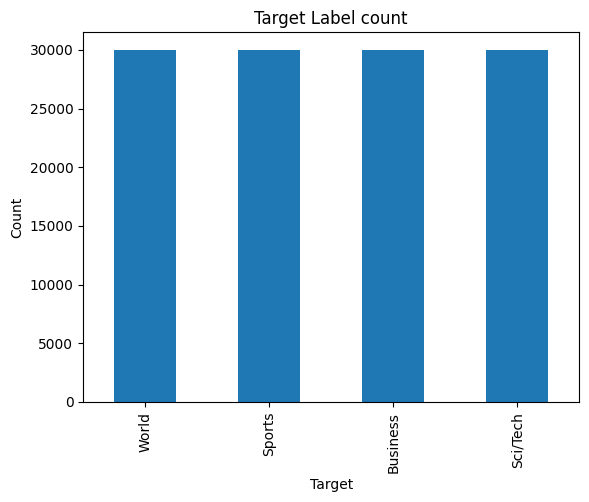

In [5]:
# Plot Label count
train_df.category.value_counts().plot(kind = 'bar')
plt.title('Target Label count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

All of the labels are equally distributed. For each label there are a total of 30K of sample records.

We don't have todo any pre-processing to get equally distributed labels.

Next let's look at the test dataset shape.

In [6]:
test_df.shape

(7600, 4)

The test dataset contains 7600 records and again 4 columns.

Let's take a look at some test dataset samples.

In [7]:
test_df.head(10)

,category,label,title,description
0,World,0,Sister of man who died in Vancouver police custody slams chief (Canadian Press),Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.
1,World,0,"Man Sought #36;50M From McGreevey, Aides Say (AP)","AP - The man who claims Gov. James E. McGreevey sexually harassed him was pushing for a cash settlement of up to #36;50 million before the governor decided to announce that he was gay and had an extramarital affair, sources told The Associated Press."
2,World,0,Explosions Echo Throughout Najaf,"NAJAF, Iraq - Explosions and gunfire rattled through the city of Najaf as U.S. troops in armored vehicles and tanks rolled back into the streets here Sunday, a day after the collapse of talks - and with them a temporary cease-fire - intended to end the fighting in this holy city..."
3,World,0,Frail Pope Celebrates Mass at Lourdes,"LOURDES, France - A frail Pope John Paul II, breathing heavily and gasping at times, celebrated an open-air Mass on Sunday for several hundred thousand pilgrims, many in wheelchairs, at a shrine to the Virgin Mary that is associated with miraculous cures. At one point he said ""help me"" in Polish while struggling through his homily in French..."
4,World,0,Venezuela Prepares for Chavez Recall Vote,Supporters and rivals warn of possible fraud; government says Chavez's defeat could produce turmoil in world oil market.
5,World,0,1994 Law Designed to Preserve Guard Jobs (AP),AP - A 1994 law strengthened job protections for National Guard and Reserve troops called to active duty. Here are major provisions of the Uniformed Services Employment and Reemployment Rights Act (USERRA).
6,World,0,Iran Warns Its Missiles Can Hit Anywhere in Israel,"TEHRAN (Reuters) - A senior Iranian military official said Sunday Israel and the United States would not dare attack Iran since it could strike back anywhere in Israel with its latest missiles, news agencies reported."
7,World,0,Afghan Army Dispatched to Calm Violence,"KABUL, Afghanistan - Government troops intervened in Afghanistan's latest outbreak of deadly fighting between warlords, flying from the capital to the far west on U.S. and NATO airplanes to retake an air base contested in the violence, officials said Sunday..."
8,World,0,Politics an Afterthought Amid Hurricane (AP),"AP - If Hurricane Charley had struck three years ago, President Bush's tour through the wreckage of this coastal city would have been just the sort of post-disaster visit that other presidents have made to the scenes of storms, earthquakes, floods and fires."
9,World,0,"Venezuelans Flood Polls, Voting Extended","CARACAS, Venezuela (Reuters) - Venezuelans voted in huge numbers on Sunday in a historic referendum on whether to recall left-wing President Hugo Chavez and electoral authorities prolonged voting well into the night."


This gives the same impression as the training dataset. Looking at some of the descriptions it is clear that this is already a bit older dataset with news articles of around 2004 - 2006 (President George Bush, President Hugo Chaves, the Iraq war etc).

Let's look at the label distribution for the test dataset.

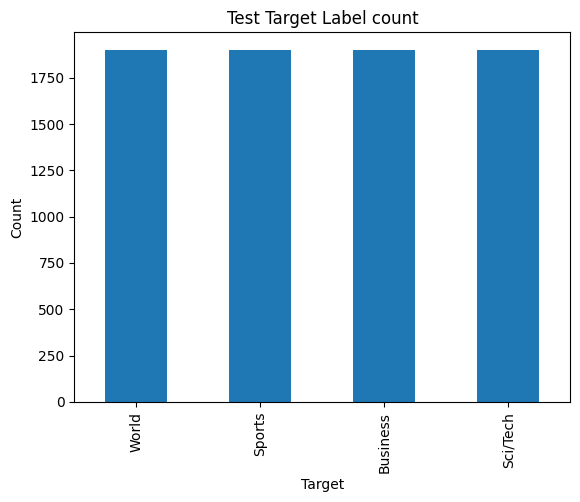

In [8]:
# Plot Label count
test_df.category.value_counts().plot(kind = 'bar')
plt.title('Test Target Label count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

The labels for the test dataset also have an equal distribution.

Next let's take a look at the distribution of the word count for each of the sample 'description'.

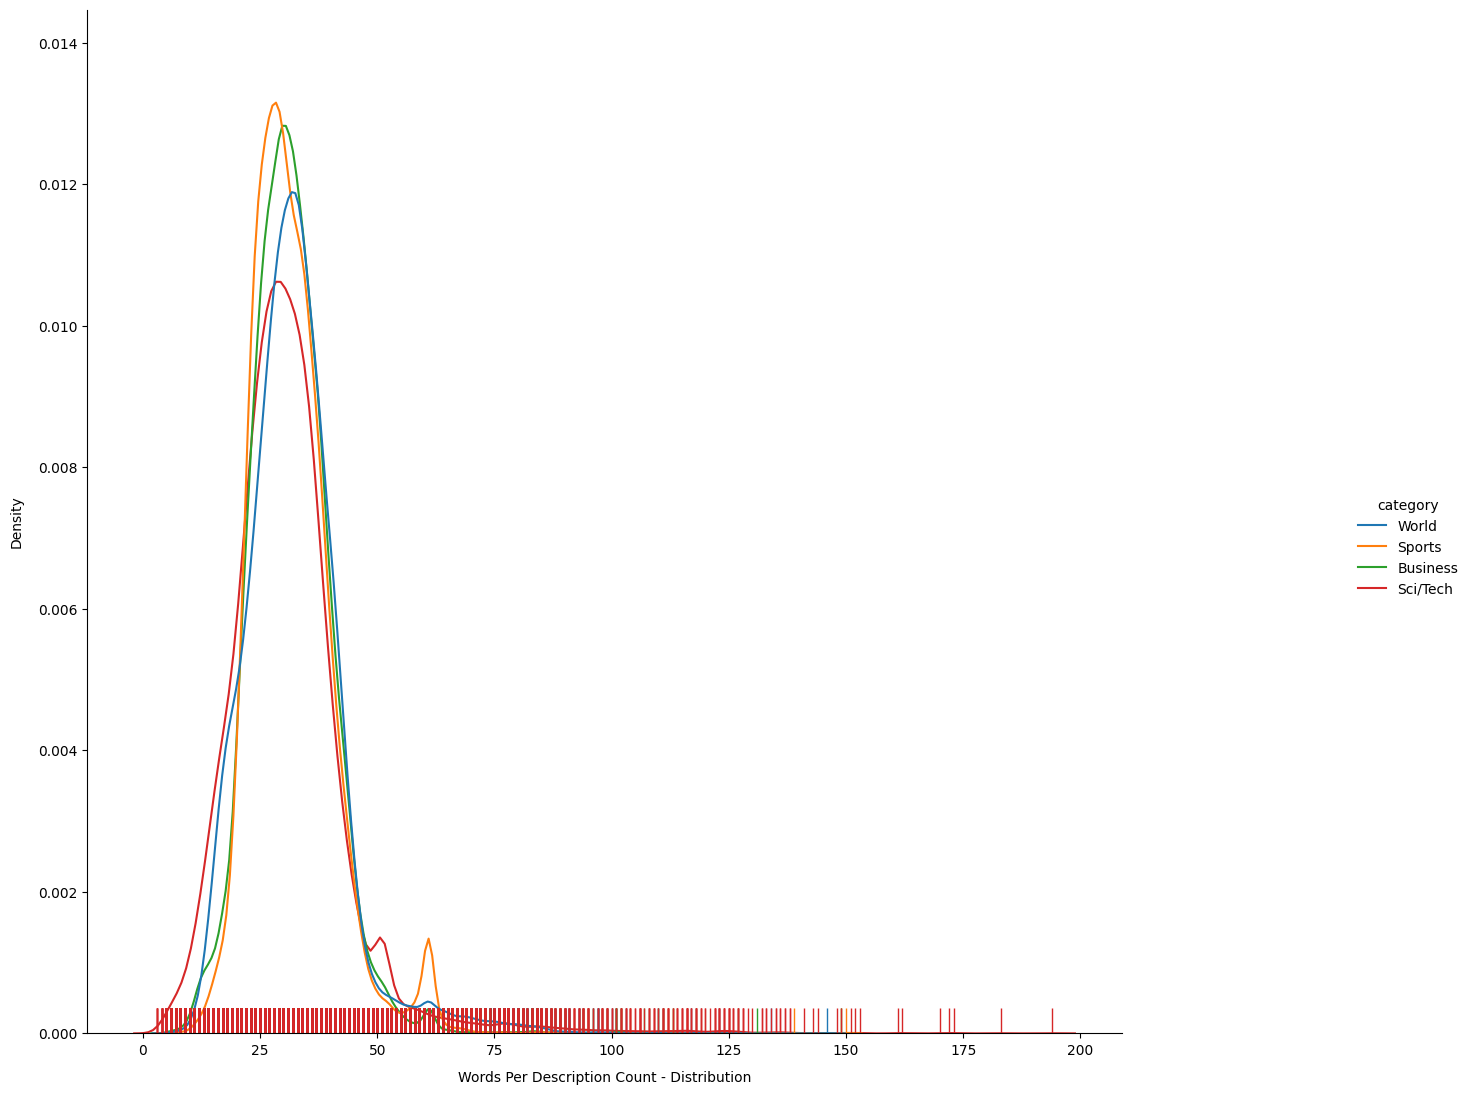

In [9]:
# Plot Description Text Word Count
train_df['description_word_count'] = train_df.description.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'description_word_count', hue = 'category')
g.set_axis_labels('Words Per Description Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of the descriptions have a word count ranging between 0 and 50 with a very few exceptions spiking up to 200 words in the description.

The distribution of the word count when looking at the specific labels is for the most part comparable.

Even though in this notebook we won't be using the 'title' it is still interresting to look at the word count distribution for it.

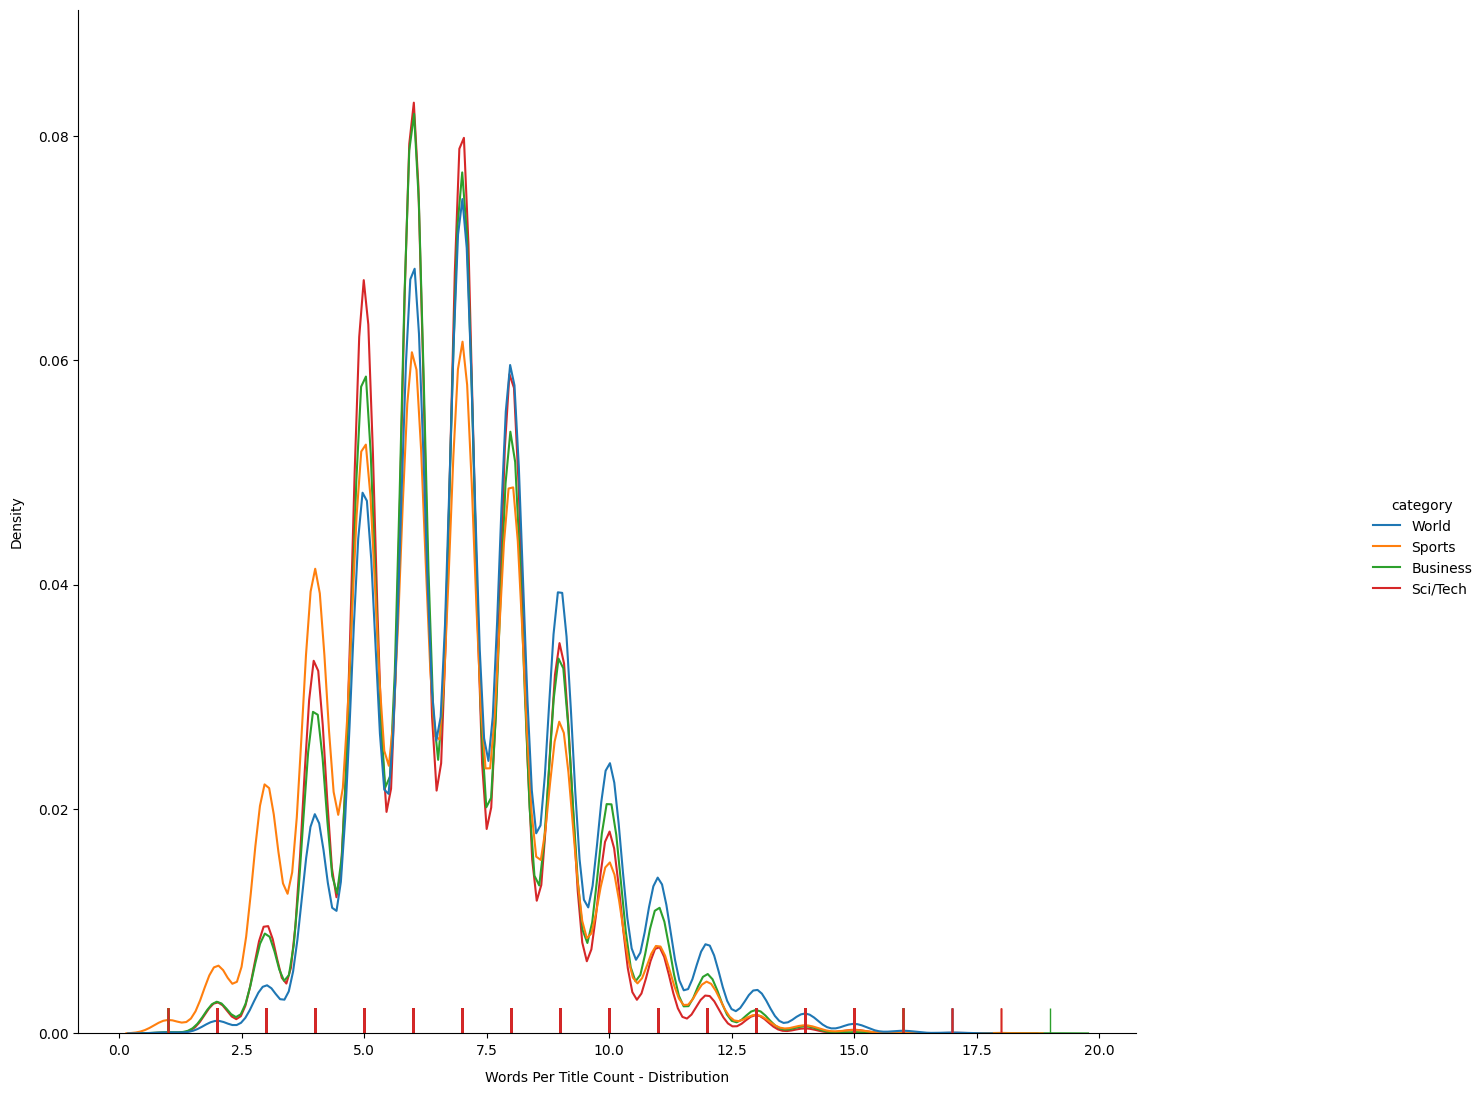

In [10]:
# Plot - Title Text Word Count
train_df['title_word_count'] = train_df.title.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'title_word_count', hue = 'category')
g.set_axis_labels('Words Per Title Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of the titles have a word count ranging between 2 - 11. The distribution per label is very similar.

We have now some insights into the number of words per title and description. 

The title we won't be using in this notebook. The description will be used extensively however...currently no text cleaning has been done.

Next we will perform some text cleaning steps:

1. Lowercase all text.
2. Remove all English Stopwords. These usually have a high occurence but add very little value.

No further text cleaning will be done.

In [11]:
# Lowercase all text
train_df.description = train_df.description.apply(str.lower)

# Remove all Stopwords.
train_df.description = train_df.description.apply(lambda x: ' '.join([stopword for stopword in x.split() if stopword not in (english_stopwords)]))

Now that the training dataset has been cleaned it is interresting to again look at the distribution of word count for the description. With the stopwords cleaned a lot of the descriptions should be shorter and hence have a lower word count.

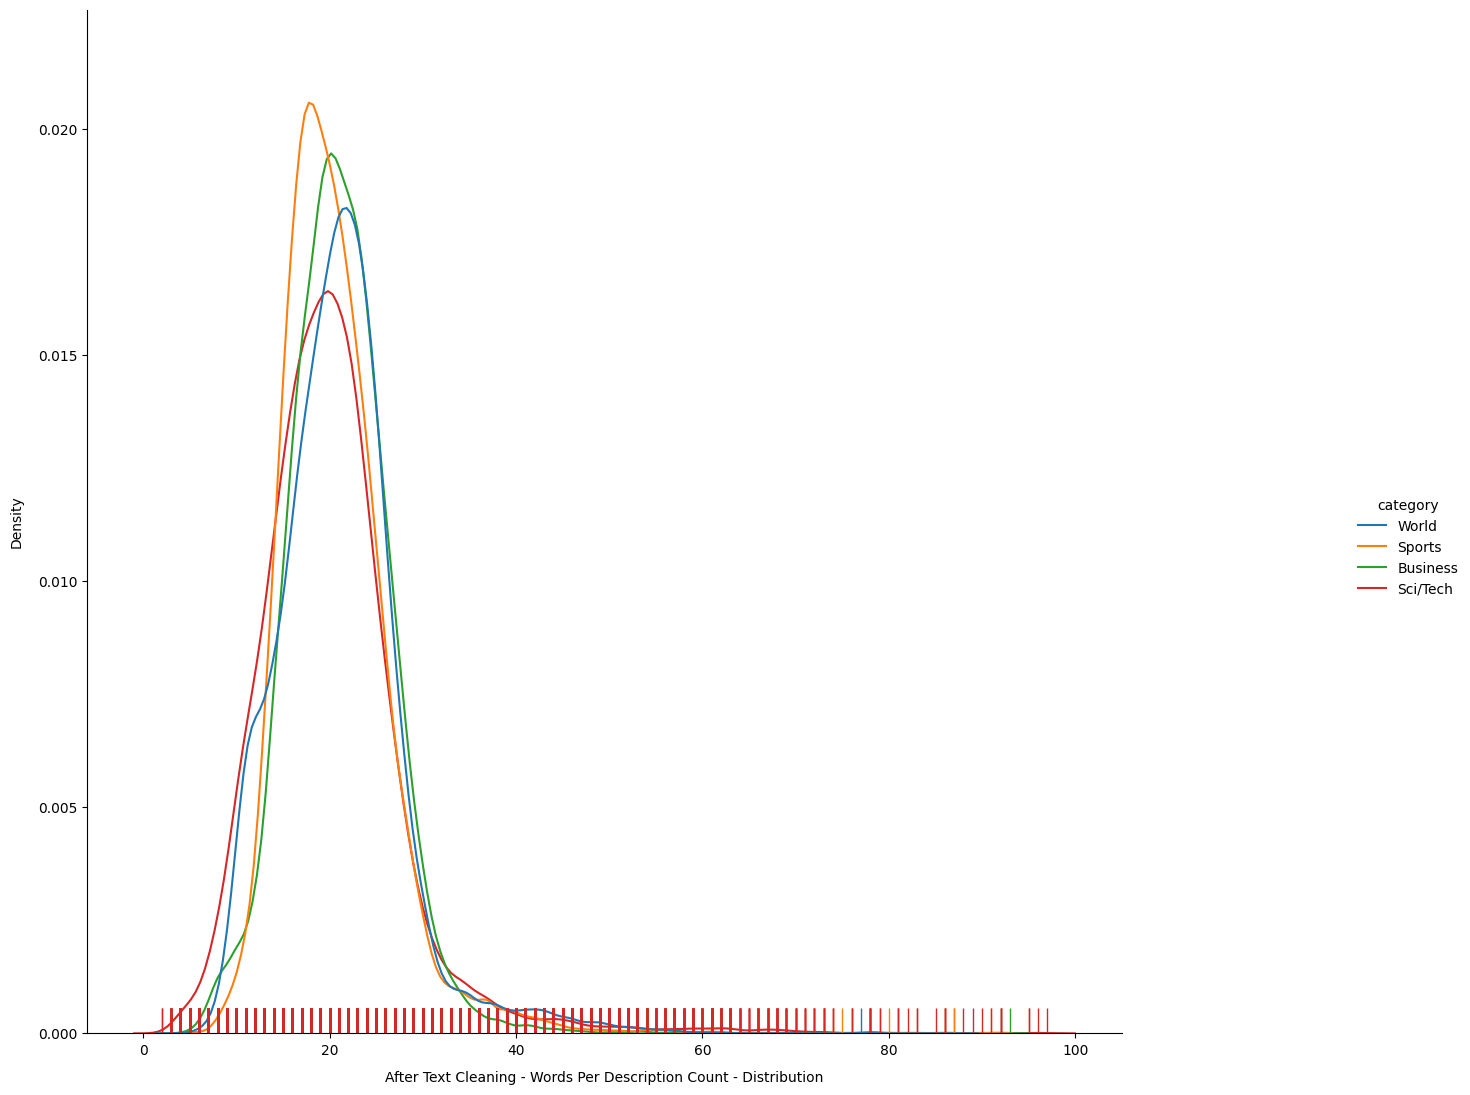

In [12]:
# Plot - Title Text Word Count
train_df['description_word_count'] = train_df.description.str.split(' ').str.len()
g = sns.displot(train_df, kind = 'kde', rug = True, x = 'description_word_count', hue = 'category')
g.set_axis_labels('After Text Cleaning - Words Per Description Count - Distribution', 'Density', labelpad = 10)
g.fig.set_size_inches(16, 12)
plt.show()
plt.close()

The majority of articles now have a word count between 0 and 40 with some outliers up to a maximum of 100 words per description.

The distribution of word count when looking at the labels is still mostly similar. Based on the distribution of the word count per label there is no need to do any processing or other data cleaning.

## 4. Models, Training and Validation

In this section we will train different KMeans clustering algorithms and one supervised learning algorithm. We will try different vectorizers and take a look at what the effect is of the amount of features that we choose.

We will try tokenization based on complete words and try using bigrams and trigrams.

Where applicable the clustering algorithms will be run with a lower number of iterations compared to the default settings. This is a trade-off I had to make to keep the total runtime within acceptable limits. When increasing the number of iterations the performance could very likely increase a little bit. The current chosen number of iterations should however still give a very good impression.

Next we set a fixed list with the values for the amount of features that we will use in each experiment.

Note! Originally I had planned to try out more and higher values of the number of features. However with the increasing runtime for the increasing number of features the total time required to run this notebook started to become unpractical. Also it turned out that increasing the amount of features beyond the current range had only minimal additional benefits.

In [13]:
# Specify List with Number of Features
nr_of_features_list = [*range(1000, 8000, 1000)]
print(nr_of_features_list)

[1000, 2000, 3000, 4000, 5000, 6000, 7000]


In the following section we setup a few supporting functions that will be called repetitively.

In [14]:
def label_permute_compare(y_gt, y_pred, n = 4):
    # Placeholders
    accuracy = 0.0
    permutation = None
    
    label_permutations = itertools.permutations(list(range(n)))    
   
    # Test Label Permutations to find the best match
    for label_permutation in list(label_permutations):
        permuted_yp = [label_permutation[label] for label in y_pred]
        acc = accuracy_score(y_gt, permuted_yp)
        if acc > accuracy:
            accuracy = acc
            permutation = label_permutation    
    
    return permutation, accuracy

def count_vectorizer(text, analyzer, ngram_range, number_features): 
    # Specify Count Vectorizer
    vectorizer = CountVectorizer(input = 'content', 
                                 encoding = 'utf-8', 
                                 strip_accents = 'unicode',
                                 ngram_range = ngram_range,
                                 analyzer = analyzer,
                                 max_features = number_features)

    # Fit CountVectorizer
    vectorizer.fit(text) 

    # Transform text with count vectorizer
    X = vectorizer.transform(text)
    
    # Summary .. uncomment to see feature names
    #print(vectorizer.get_feature_names_out()[:8])

    return X

def tfidf_vectorizer(text, analyzer, ngram_range, number_features):
    # Specify TfIdf Vectorizer
    vectorizer = TfidfVectorizer(input = 'content', 
                                 encoding = 'utf-8', 
                                 strip_accents = 'unicode',
                                 ngram_range = ngram_range,
                                 analyzer = analyzer, 
                                 max_features = number_features)

    # Fit TfIdfVectorizer
    vectorizer.fit(text) 

    # Transform text with tfidf vectorizer
    X = vectorizer.transform(text)
    
    # Summary .. uncomment to see feature names
    #print(vectorizer.get_feature_names_out()[:8])

    return X

def show_summary_and_plot(plot_title, train_acc, val_acc):    
    # Print Summary
    max_trainacc_x = (np.argmax(train_acc) + 1) * 1000
    max_trainacc_y = np.max(train_acc)
    print(f'Best Train Accuracy: {max_trainacc_y:.4f} with Number Of Features: {max_trainacc_x}')
    max_valacc_x = (np.argmax(val_acc) + 1) * 1000
    max_valacc_y = np.max(val_acc)
    print(f'Best Validation Accuracy: {max_valacc_y:.4f} with Number Of Features: {max_valacc_x}')

    # Plot Results
    plt.figure(figsize = (12, 8))
    plt.title(plot_title)
    plt.plot(nr_of_features_list, train_acc, label = 'Training Accuracy')
    plt.plot(nr_of_features_list, val_acc, label = 'Validation Accuracy')
    plt.scatter(max_trainacc_x, max_trainacc_y, c = 'r', label = 'Maximum Training Accuracy')
    plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
    plt.xlabel('Number Of Features')
    plt.xticks(nr_of_features_list)
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

### 4.0 Scikit-Learn KMeans - Count Vectorizer - Words

Our first experiment will be with the KMeans clustering implementation as is available through the Scikit-Learn library. Since we have 4 different labels in the training set we specify the amount of clusters to be 4.

The vectorizer in this experiment is the CountVectorizer. With the analyzer set to 'word' and ngram_range to (1,1) the tokens that will be used are the complete words. 

The number_of_features to use is specified in the list nr_of_features_list. This number is used to determine the Top K number of words that the CountVectorizer will consider.
This list will be used in a for loop and for each loop the training and validation accuracy will be stored in placeholder lists.

Afterwards the performance metrics will be shown in a plot.

Best Train Accuracy: 0.3050 with Number Of Features: 3000
Best Validation Accuracy: 0.3038 with Number Of Features: 4000


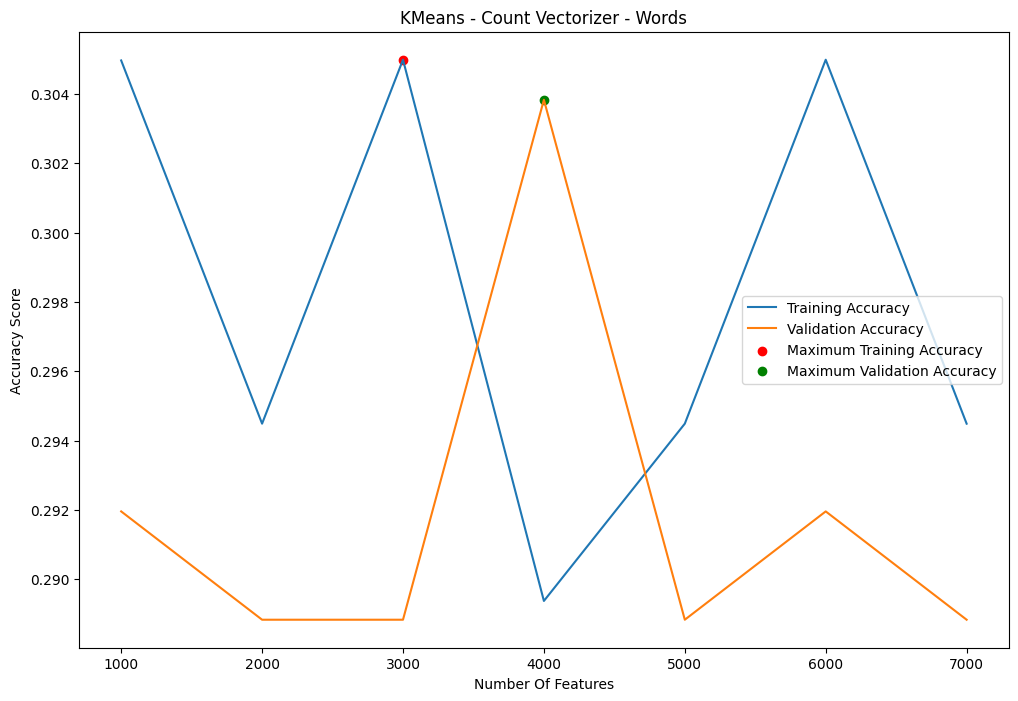

In [15]:
# Placeholders
train_acc, val_acc = [], []

# Loop
for number_of_features in nr_of_features_list:
    # Prepare Train Test Features
    X = count_vectorizer(train_df.description, 
                         analyzer = 'word', 
                         ngram_range = (1, 1), 
                         number_features = number_of_features)
    y = train_df.label

    # Train Test Split
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.20, 
                                                          stratify = y, 
                                                          shuffle = True, 
                                                          random_state = 42)

    # Cast Int64 to Int16 to save memory
    x_train = x_train.toarray().astype(np.int16)
    x_valid = x_valid.toarray().astype(np.int16)

    # Create Model
    model = KMeans(n_clusters = 4, 
                   n_init = 25, 
                   max_iter = 50)

    # Training Set
    model.fit(x_train)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_train, y_pred)
    train_acc.append(acc)

    # Validation Set
    model.fit(x_valid)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_valid, y_pred)
    val_acc.append(acc)

# Print Summary and Plot
show_summary_and_plot('KMeans - Count Vectorizer - Words', train_acc, val_acc)

### 4.1 Scikit-Learn KMeans - TfIdf Vectorizer - Words

In the next experiment the setup will be equal to the previous one except that we will be using the TfIdfVectorizer instead of the CountVectorizer. Where the CountVectorizer only counts the words the TfIdfVectorizer applies a more 'intelligent' algorithm. This should give better text vectors in theory.

Lets run the experiment.

Best Train Accuracy: 0.4293 with Number Of Features: 3000
Best Validation Accuracy: 0.4350 with Number Of Features: 2000


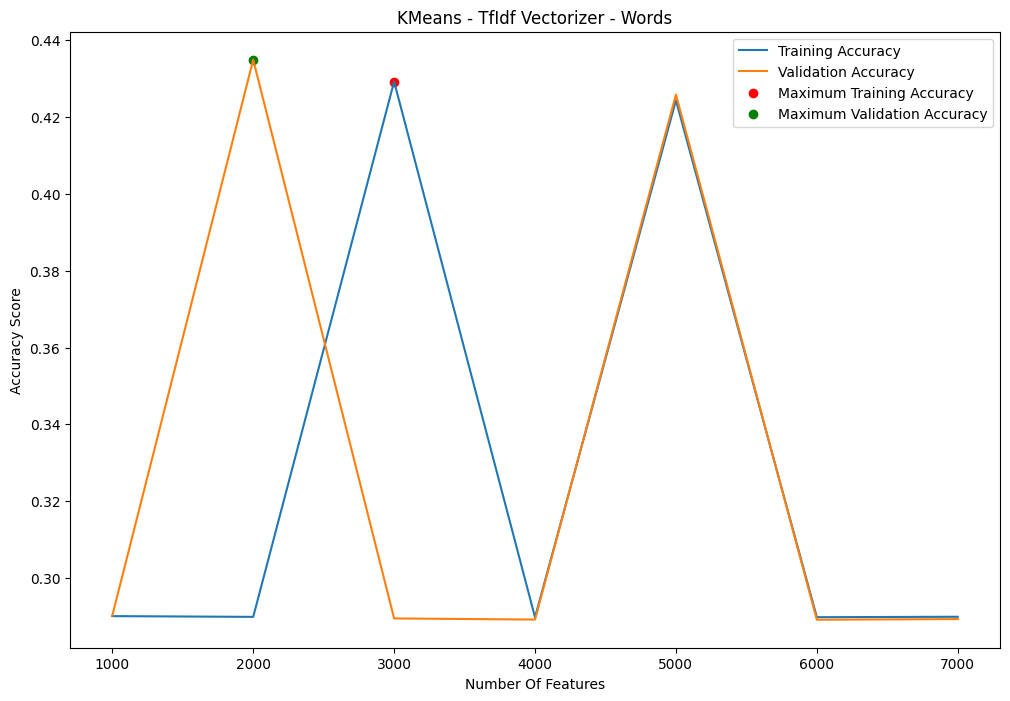

In [16]:
# Placeholders
train_acc, val_acc = [], []

# Loop
for number_of_features in nr_of_features_list:
    # Prepare Train Test Features
    X = tfidf_vectorizer(train_df.description, 
                         analyzer = 'word', 
                         ngram_range = (1, 1), 
                         number_features = number_of_features)
    y = train_df.label

    # Train Test Split
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.20, 
                                                          stratify = y, 
                                                          shuffle = True, 
                                                          random_state = 42)

    # Cast Float64 to Float16 to save memory
    x_train = x_train.toarray().astype(np.float16)
    x_valid = x_valid.toarray().astype(np.float16)

    # Create Model
    model = KMeans(n_clusters = 4, 
                   n_init = 25, 
                   max_iter = 50)

    # Training Set
    model.fit(x_train)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_train, y_pred)
    train_acc.append(acc)

    # Validation Set
    model.fit(x_valid)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_valid, y_pred)
    val_acc.append(acc)

# Print Summary and Plot
show_summary_and_plot('KMeans - TfIdf Vectorizer - Words', train_acc, val_acc)

### 4.2 Scikit-Learn KMeans - TfIdf Vectorizer - Trigrams and Quadrigrams

In the previous experiment we already saw that using the TfIdf Vectorizer instead of the Count Vectorizer gave us a nice performance boost.

In the next experiment we will therefore stick to the TfIdf Vectorizer but we will modify how the text is analyzed and processed before the TfIdf algorithm is run.

By modifying the analyzer to 'char_wb' and setting the ngram_range to (3, 4) the TfIdf algorithm will analyze based on the created Trigrams and Quadrigrams. With the smaller parts of the words that these cover there should be more granularity in processing the text. 

The rest of the experiment remains the same. We still use the Scikit-Learn KMeans implementation to be able to make comparisons.

Best Train Accuracy: 0.6164 with Number Of Features: 6000
Best Validation Accuracy: 0.6198 with Number Of Features: 7000


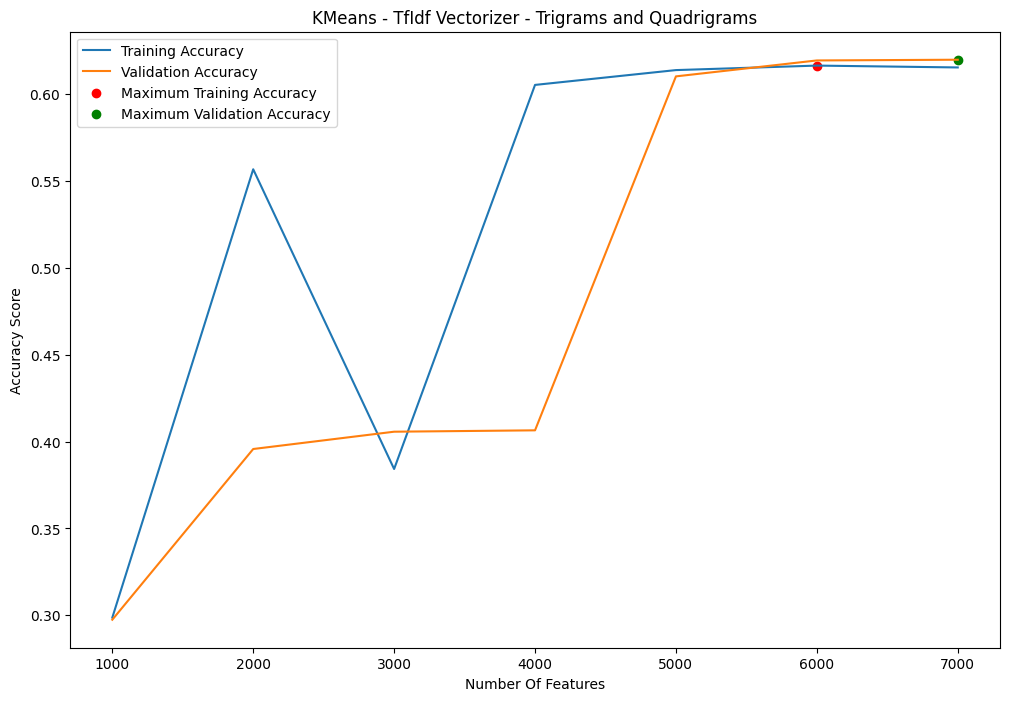

In [17]:
# Placeholders
train_acc, val_acc = [], []

# Loop
for number_of_features in nr_of_features_list:
    # Prepare Train Test Features
    X = tfidf_vectorizer(train_df.description, 
                         analyzer = 'char_wb', 
                         ngram_range = (3, 4), 
                         number_features = number_of_features)
    y = train_df.label

    # Train Test Split
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.20, 
                                                          stratify = y, 
                                                          shuffle = True, 
                                                          random_state = 42)

    # Cast Float64 to Float16 to save memory
    x_train = x_train.toarray().astype(np.float16)
    x_valid = x_valid.toarray().astype(np.float16)

    # Create Model
    model = KMeans(n_clusters = 4, 
                   n_init = 25, 
                   max_iter = 50)

    # Training Set
    model.fit(x_train)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_train, y_pred)
    train_acc.append(acc)

    # Validation Set
    model.fit(x_valid)
    y_pred = model.labels_
    labelorder, acc = label_permute_compare(y_valid, y_pred)
    val_acc.append(acc)

# Print Summary and Plot
show_summary_and_plot('KMeans - TfIdf Vectorizer - Trigrams and Quadrigrams', train_acc, val_acc)

### 4.3 FAISS KMeans - TfIdf Vectorizer - Trigrams and Quadrigrams

In the next experiment we will remain using the TfIdf Vectorizer with Trigrams and Quadrigrams. 

This time however as algorithm we will be using the KMeans implementation from FAISS. The libraries from FAISS are highly optimized for performance.

Let's see what results we can get with their implementation.

Best Train Accuracy: 0.6297 with Number Of Features: 7000
Best Validation Accuracy: 0.5870 with Number Of Features: 6000


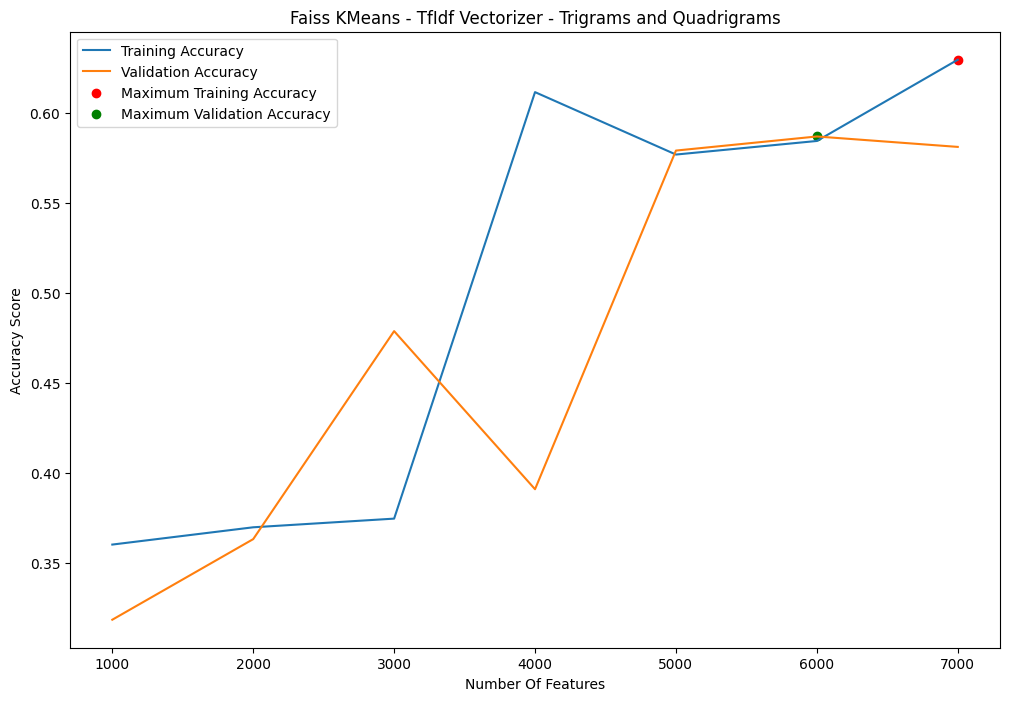

In [19]:
# Placeholders
train_acc, val_acc = [], []

# Loop
for number_of_features in nr_of_features_list:
    # Prepare Train Test Features
    X = tfidf_vectorizer(train_df.description, 
                         analyzer = 'char_wb', 
                         ngram_range = (3, 4), 
                         number_features = number_of_features)
    y = train_df.label

    # Train Test Split
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.20, 
                                                          stratify = y, 
                                                          shuffle = True, 
                                                          random_state = 42)

    # Cast Float64 to Float16 to save memory
    x_train = x_train.toarray().astype(np.float16)
    x_valid = x_valid.toarray().astype(np.float16)

    # Create Model
    model = faiss.Kmeans(d = x_train.shape[1], 
                         k = 4, 
                         nredo = 25,
                         niter = 50)

    # Training Set
    model.train(x_train)
    y_pred = model.index.search(x = x_train, k = 1)[1].reshape(-1)
    labelorder, acc = label_permute_compare(y_train, y_pred)
    train_acc.append(acc)

    # Validation Set
    model.train(x_valid)
    y_pred = model.index.search(x = x_valid, k = 1)[1].reshape(-1)
    labelorder, acc = label_permute_compare(y_valid, y_pred)
    val_acc.append(acc)

# Print Summary and Plot
show_summary_and_plot('Faiss KMeans - TfIdf Vectorizer - Trigrams and Quadrigrams', train_acc, val_acc)

### 4.4 Gradient Boosting Classifier - TfIdf Vectorizer - Trigrams and Quadrigrams

As a last experiment - and again we will remain using the TfIdf Vectorizer with the Trigrams and Quadrigrams - we will train a supervised model (GradientBoostingClassifier) to be able to compare the unsupervised model against a supervised model.

To keep the performance / total running time of the model comparable to the unsupervised models the number of estimators is limited to 50. Also max_features is set to 0.05. This way only a subset of the total features is selected. Normally this is used to prevent overfitting...it is however also a perfect setting to limit the total running time.

Best Validation Accuracy: 0.7538 with Number Of Features: 7000


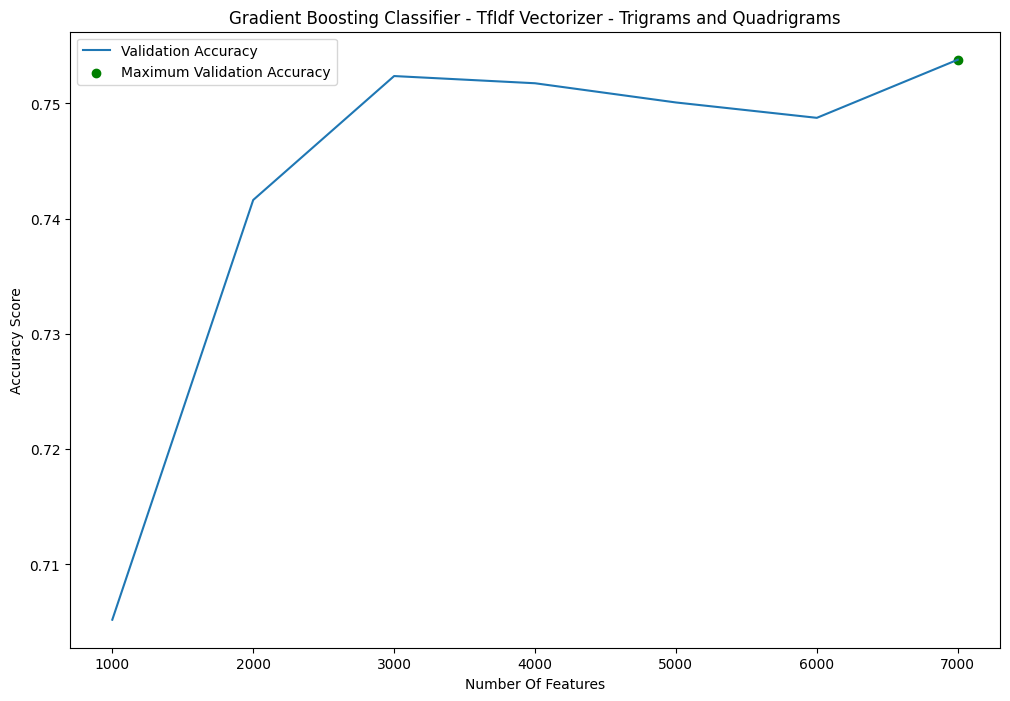

In [21]:
# Placeholders
val_acc = []

# Loop
for number_of_features in nr_of_features_list:
    # Prepare Train Test Features
    X = tfidf_vectorizer(train_df.description, 
                         analyzer = 'char_wb', 
                         ngram_range = (3, 4), 
                         number_features = number_of_features)
    y = train_df.label

    # Train Test Split
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size = 0.20, 
                                                          stratify = y, 
                                                          shuffle = True, 
                                                          random_state = 42)
    
    # Cast Float64 to Float16 to save memory
    x_train = x_train.toarray().astype(np.float16)
    x_valid = x_valid.toarray().astype(np.float16)

    # Create Model
    model = GradientBoostingClassifier(learning_rate = 0.02, 
                                       n_estimators = 50, 
                                       subsample = 0.8,
                                       max_features = 0.05,
                                       criterion = 'friedman_mse', 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       min_weight_fraction_leaf = 0.0, 
                                       max_depth = 4)

    # Fit Model
    model.fit(x_train, y_train)

    # Validation Set
    y_pred = model.predict(x_valid)
    val_acc.append(accuracy_score(y_valid, y_pred))

# Print Summary
max_valacc_x = (np.argmax(val_acc) + 1) * 1000
max_valacc_y = np.max(val_acc)
print(f'Best Validation Accuracy: {max_valacc_y:.4f} with Number Of Features: {max_valacc_x}')

# Plot Results
plt.figure(figsize = (12, 8))
plt.title('Gradient Boosting Classifier - TfIdf Vectorizer - Trigrams and Quadrigrams')
plt.plot(nr_of_features_list, val_acc, label = "Validation Accuracy")
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Number Of Features')
plt.xticks(nr_of_features_list)
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

## 5. Hyperparameter tuning - FAISS KMeans - TfIdf Vectorizer - Trigrams and Quadrigrams

In this section we will do a gridsearch to perform some hyperparameter tuning. We already witnessed in the previous section that the FAISS KMeans algorithm has the shortest runtime because of all the optimizations done on this library. It also achieves the highest accuracy.

For the KMeans algorithm a number of initialization iterations can be specified and a number of main iterations.

In this section we will investigate what the relation is between the 2 and with what combination we can get the highest accuracy with the least amount of iterations.

In earlier experiments the highest accuracy was achieved with the TfIdf Vectorizer with trigrams and quadrigrams with 7000 features specified. We will again use that as a basic configuration to start from.

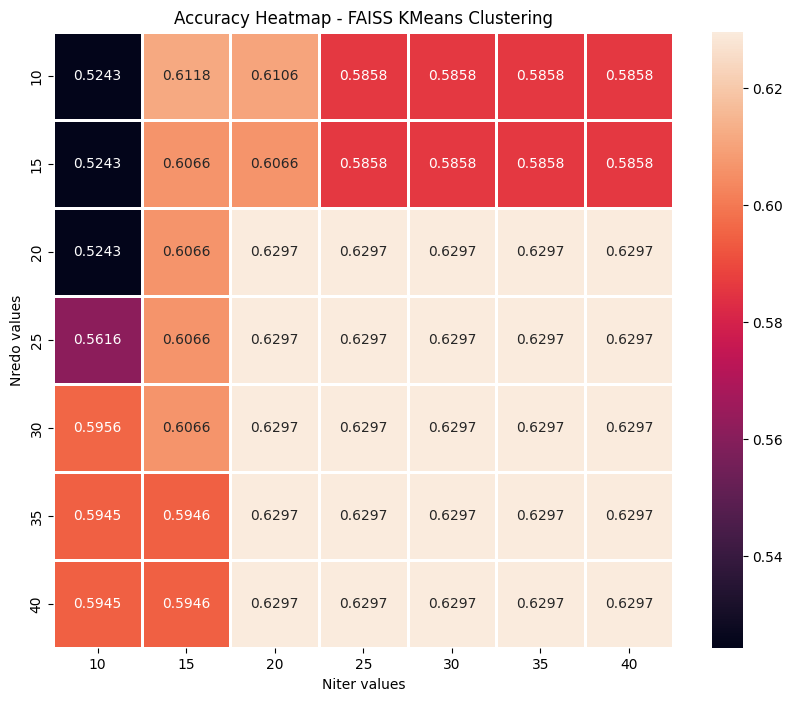

In [23]:
# Placeholders
nredo_list = [*range(10, 45, 5)]
niter_list = [*range(10, 45, 5)]

# Prepare Train Test Features
X = tfidf_vectorizer(train_df.description, 
                     analyzer = 'char_wb', 
                     ngram_range = (3, 4), 
                     number_features = 7000)
y = train_df.label

# Train Test Split
x_train, x_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size = 0.20, 
                                                      stratify = y, 
                                                      shuffle = True, 
                                                      random_state = 42)

# Cast Float64 to Float16 to save memory
x_train = x_train.toarray().astype(np.float16)
x_valid = x_valid.toarray().astype(np.float16)

# Results Place Holder
heatmap_matrix = np.zeros((len(nredo_list), len(niter_list)))

# Use Nested Loop
for i, nredo in enumerate(nredo_list):
    for j, niter in enumerate(niter_list):

        # Create Model
        model = faiss.Kmeans(d = x_train.shape[1], 
                             k = 4, 
                             niter = niter, 
                             nredo = nredo)

        # Training Set
        model.train(x_train)
        y_pred = model.index.search(x = x_train, k = 1)[1].reshape(-1)
        labelorder, acc = label_permute_compare(y_train, y_pred)

        # Heatmap Result
        heatmap_matrix[i, j] = acc

# Plot Accuracy Heatmap
plt.rcParams["figure.figsize"] = (10, 8)
ax = sns.heatmap(heatmap_matrix, 
                 annot = True,
                 xticklabels = niter_list,
                 yticklabels = nredo_list,
                 fmt = '.4f',
                 linewidth = 1.0)
ax.set(xlabel = 'Niter values', ylabel = 'Nredo values')
ax.set(title = 'Accuracy Heatmap - FAISS KMeans Clustering')
plt.show()
plt.close()

## 6. Results and Analysis

In our first experiment we ran the SKLearn KMeans algorithm on text input that was vectorized based on the Count Vectorizer with regular words as the tokens. With a performance of around 30% accuracy for both training and validation datasets this is clearly not a good performance. With the numerical values determined by the counting of words this does not guarantee that a word is important. A word with a high occurence is not necessarily an important one.

In the next experiment we kept using the SKLearn KMeans algorithm but we switched from using the Count Vectorizer to the TfIdf Vectorizer with regular words used as the tokens. TfIdf stands for Term Frequence Inverse Document Frequence. There is a large theoretical explanation which can be found at various internet sites. Overly simplified it more or less means that the less frequent a word is the higher its information value is. If we then use that algorithm to vectorize our input text we can observice that we have an almost 50% performance increase compared to the CountVectorizer. With a score of 43.5% on the validation dataset we have a good improvement. This score is achieved with 2000 features. For the different number of features values there can be large differences between 29% - 43.5% on the training and validation set accuracy scores. I have no clear explanation why this is occuring.

In the third experiment we continue with the SKLearn KMeans algorithm and the TfIdf Vectorizer as that vectorizer clearly improves the performance compared to the Count Vectorizer. This time however the TfIdf algorithm will not run based on the frequencies of regular words but we will configure the vectorizer to run based on 3 and 4 letter subwords - the so called trigrams and quadrigrams. If we look at the plot of the accuracy score for the training and validation set then we now almost approach a score of 62% which is again significantly higher than the 43.5% of the previous experiment.
The plot also shows clearly that the accuracy improves with increasing number of features. The best achieved accuracy of 62% occured for the maximum number of features used.

The fourth experiment is basically the same as the third. The only change is that we use the KMeans implementation from FAISS. FAISS is a library that is highly optimized for performance. 
The total runtime for the third experiment is around 39 minutes. With the use of the FAISS library the runtime is little over 4 minutes. This is a performance increase of almost 10 times. With a maximum accuracy of 63% at 7000 features used the achieved score is similar to the SKLearn KMeans implementation.

In the last experiment we train a GradientBoostingClassifier to predict the labels. With a runtime similar to the SKLearn Kmeans algorithm it achieves a performance of little over 75% with 7000 features used. This supervised model is clearly able to achieve a higher performance than our current best unsupervised model.

In the hypertuning section we looked at how much initialization iterations and main iterations are required to achieve maximum accuracy. If we look at the heatmap we can observe that with 20 initializations iterations and 20 main iterations we already achieve the highest performance of 63%. There is no need to run more iterations.

## 7. Conclusion

In this notebook we looked at the effect of using the Count Vectorizer or the TfIdf Vectorizer. We observed that using the TfIdf Vectorizer gives a clear perfomance improvement. Using the TfIdf Vectorizer with the configuration setup to use trigrams and quadrigrams delivers even more accuracy improvements. Increasing the number of features further adds up to the achieved performance.

We performed various experiments with 2 different KMeans implementations. We observed that the FAISS KMeans implementation is up to 10 times faster than the SKLearn KMeans implementation. 

The highest accuracy we achieved with the FAISS KMeans unsupervised model is 63%. We also trained a supervised model - GradientBoostingClassifier - which achieved 75% accuracy. When accuracy is important than it is preferable to use a supervised model.

With the hypertuning we determined that we only need 40 iterations with FAISS KMeans to already reach maximum performance.